In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from math import *
import copy



N=250  #Number of samples

def par_to_list(filename):        #Parses txt file where I saved all the 8 parameters

    infile=open(filename,'r')
    result=np.zeros((N,8))
    time=np.zeros(N)

    i=0
    for line in infile:

        for j in range(len(line.split())):
            if j<8:
                result[i,j]=float(line.split()[j])
            else:
                time[i]=float(line.split()[j])
    
        i+=1
        if i==N-1:
            break

    infile.close()  

    for i in range(N):           #I normalize some of the parameters, so that all of them are of the order of 1
        result[i,0]/=10
        result[i,3]/=10**4
        result[i,4]/=10**3
        result[i,5]/=100
        result[i,6]/=10**3


    return result,time


def ccr_to_list(filename):        #Parses txt file with cross-correlations. Next time, I'll use hdf5 files.

    infile=open(filename,'r')
    result=np.zeros((N,N),dtype=(float,3))

    i=0
    for line in infile:
        line=line.replace('(',"")
        line=line.replace(')',"")

        for j in range(i+1,N):
            j_ind=j*3
            tupl=line.split()[j_ind:j_ind+3]
                
            result[i,j]=(float(tupl[0])/1000,float(tupl[1])/10,float(tupl[2])/1000) #Normalization to order of 1.
            result[j,i]=result[i,j]
        i+=1
        if i==N-1:
            break


    infile.close()  
    return result




In [3]:
PAR,T=par_to_list("parameters.txt")
CCR=ccr_to_list("cross_corrs.txt")

In [4]:
def distance(i,j,ps,cs):            #Definition of ditance using given parameters. Currently distance for parameters from PAR is
                                    #calculated by summing squares of differneces. For cross-correlation, these are now taken as
                                    #1/x and squared (in general higher cross-correlation leads to smaller distance between time
                                    #to event, so 1/x is only one of many options).

    va=PAR[i]
    vb=PAR[j]



    dist=0
    # den=0
    for k in range(8):
        dist+=ps[k]*(va[k]-vb[k])**2
    

    for k in range(3):
        # den+=cs[k]*(CCR[i,j][k])**2
        dist+=cs[k]/(CCR[i,j][k])**2

    # dist=sqrt(dist/den)

    return sqrt(dist)

def estimate(ind,all_inds,ps,cs,k,weighted,includes):       #This function calculates distances between parameters' vector of 
                                                            #index "ind" and vectors with indeciex from list "all_inds". Next,
                                                            #the list of tuples (distance,index) is sorted by the distance and
                                                            #time to event of the "ind" vector is etimated using "k" closest
                                                            #vectors. If "weighted" is set to True, estimate is done using a 
                                                            #wieghted average with weight=1/distance. "includes" is there
                                                            #in case index "ind" belongs to list "all_inds".

    dists=[]

    for i in all_inds:
        if includes:
            if i!=ind:
                dists.append((distance(ind,i,ps,cs),i))
        else:
            dists.append((distance(ind,i,ps,cs),i))
    dists=sorted(dists,key=lambda x: x[0])


    estimate=0
    if weighted:
        weight=0
        for i in range(k):
        
            estimate+=T[dists[i][1]]/dists[i][0]
            weight+=1/dists[i][0]

        return estimate/weight
    else:
        for i in range(k):
            
            estimate+=T[dists[i][1]]

        return estimate/k


def score(ind,est):           #Simply returns error of the estimate for a single sample vector.
    return abs(T[ind]-est)


def get_training_score(tr_sample,ps,cs,k):  #Calculates score (error) for a training sampel of vectors with indecies in 
                                            #"tr_sample". It does that by taking every index in the training sample and
                                            #estimating time to event using the remaining indecies. 

    scr=0
    k=int(k)

    for x in tr_sample:

        est=estimate(x,tr_sample,ps,cs,k,True,True)
        scr+=score(x,est)

    return scr/len(tr_sample)


def get_validation_error(test_sample,training_sample,ps,cs,k):  #Calculates score (error) for a test sample. It estimates time
                                                                #to event for vectors with indecies in "test_sample" using
                                                                #vectors with indecies in "training_sample".
    validate_error=0
    k=int(k)
    for i in test_sample:
        est=estimate(i,training_sample,ps,cs,k,True,False)
        validate_error+=score(i,est)

    return validate_error/len(test_sample)

def training_sample(tr_size):      #Creates a training sample.
  
    return random.sample(range(N),tr_size)

def test_sample(training_sample,full_sample):   #Creates a test sample=set(full_sample)-set(training_sample).
    return [i for i in full_sample if i not in training_sample]

<b>k-Nearest Neighbors trained using genetic optimization</b>

Algorithm is quite long, so let me first explain what I'm trying to do here...

k-NNs in general estimates time to event using function <i>estimate</i>. So, here I first remove random <b>fin_test</b> number of samples from the whole pool, which are used to independently check error at every iteration. Then, the k-NN parameters are trained using <b>tr_size</b> sample from the ramining training sample, and test set of size <b>N-tr_size-fin_test</b>, i.e. I calculate error by estimating times to event for the vectors with indecies in test set by using vectors with indecies remaining in the training set. Then, I resample <b>resampling</b> number of times hoping to generalize the result.

The genetic optimization algorithm works by first creating a population, where every member of the population is a vector containing optimized parameters. Here, such a member has 11 parameters used to calculate the distance between two vectors (8 for parameters from <b>PAR</b> and 3 for paramemeters from <b>CCR</b>), plus an additional parameter <b>k</b> telling us how many nearest neighbors to use. Every parameter has a lower and upper bound definied by an array <b>Domain</b>.

First, I generate <b>popsize</b> number of members of the population (<b>pop</b>). For every member I calculate score (error) for the test sample using the training sample. Afterwards, I sort the population in ascending order (the smaller the error, the better) and choose only <b>elite</b> number of top members. At the end of iteration, I create <b>popsize</b>-<b>elite</b> number of new members by either: mutation or crossover of the top <b>elite</b> members of the population.

List <b>probabilities</b>defines probabilities of different kind of mutations/crossovers occuring: if generated random number is smaller than <b>probabilities[0]</b> , then mutation happens only at one random parameter, if it is between <b>probabilities[0]</b> and <b>probabilities[1]</b>, it occurs at random parameters, and so on. If the random number is between <b>probabilities[11]</b> and <b>probabilities[12]</b>, a fully new vector is created. Finally, for random numbers bigger than <b>probabilities[12]</b> crossover occurs. Mutation is process, where random parameter(s) are changed by a small random fraction of its(their) allowed domain. Crossover combines two vectors at a random point. This process is repeated <b>iterations</b> number of times for one instance of resampling.

Finally, the process is started all over from the beginning <b>optimizations</b> number of times. After each run, the final best members of the population are added to final population, which then is run on a full sample (that is also including the sample removed at the very beginning). A full sample is randomly divided into training and testing part (like at the beginning of every resampling loop), after which it is used for training <b>2 x iterations</b> number of times. The whole function returns array contatining training and test errors for all the optimization processes, final training errors for the final population, and the top 5 parameters' vectors.

In [27]:
def optimize_knns(tr_size,fin_test,popsize=50,iterations=50,resampling=10,optimizations=3):

    #Samples for  training and testing
    
    Training_errors=np.zeros((iterations*resampling,optimizations))    
    Test_errors=np.zeros((iterations*resampling,optimizations))
    Fin_training_errors=np.zeros(2*iterations)

    train=training_sample(N-fin_test)
    test=test_sample(train,range(N))
    test_last=random.sample(train,N-tr_size-fin_test)

    N_pars=8+3+1 #Number of optimized parameters

    
    
    #Domain for optimized parameters
    
    Domain=np.zeros((N_pars,2))
    for i in range(N_pars):
        Domain[i,1]=10

    Domain[N_pars-1,1]=15
    Domain[N_pars-1,0]=1

    
    
    #Fraction of population being saved for the next iteration and used to create offspring
    
    elite_frac=0.25

    elite=int(elite_frac*popsize)

    
    
    #Probabilities of mutations and crossovers
    
    probabilities=[0]*13

    probabilities[0]=0.2 #20% for mutating one random parameter
    probabilities[1]=0.3 #10% for mutating two random parameters
    probabilities[2]=0.38 #8% for 3
    probabilities[3]=0.44 #6% for 4
    probabilities[4]=0.49 #5% for 5
    probabilities[5]=0.53 #4% for 6
    probabilities[6]=0.55 #2% for 7
    probabilities[7]=0.56 #1% for 8
    probabilities[8]=0.57 #1% for 9
    probabilities[9]=0.58 #1% for 10
    probabilities[10]=0.59 #1% for 11
    probabilities[11]=0.595 #0.5% for mutating all 12 parameters
    probabilities[12]=0.62 #2.5% to create totally new 12 parameters
                           #38% for crossover
        
        
        
    #Best training score (lowest error) and corresponding parameters will be saved here
    
    best=[0]*(N_pars+1)
    best[-1]=10**6


    
    #Final population container
    
    final_pop=np.zeros((popsize,N_pars))

    

    #Optimization starts here
    
    for l in range(optimizations):   #This loops over number of times the whole process starts from a new random population
       
        print("Population",l+1)

        
        #Creating random population
        
        pop=np.zeros((popsize,N_pars))  #Container for the population
        
        for i in range(popsize):  #Every parameter is chosen randomly between its lower and upper bounds
            for j in range(N_pars):
                pop[i,j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]
            pop[i,N_pars-1]=random.randint(Domain[N_pars-1,0],Domain[N_pars-1,1])

            
        for s in range(resampling): #This loops over number of times the same population is trained using different samples

            print("Sampling", s+1)

            
            #Creating new sample
            
            curr_train=random.sample(train,tr_size)  #Training sample
            curr_test=test_sample(curr_train,train)  #Test sample

            
            
            for i in range(iterations): #This loops over number of times scores are calculated for the same train and test
                                        #samples and population is evolved.

                print("Iteration",i+1)
                
                
                
                #Calculating scores for training

                scores=np.zeros((popsize,N_pars+1))
                scores[:,0:N_pars]=pop   #First N_pars elements of a row are just parameters in the population, the last 
                                         #element will be the score

                for j in range(popsize):

                    scores[j,N_pars]=get_validation_error(curr_test,curr_train,pop[j,0:8],pop[j,8:11],pop[j,11])

                scores=np.array(sorted(scores,key=lambda x: x[-1]))  #Sorting with respect to obtained scores

                if scores[0,N_pars]<best[-1]:
                    best=scores[0]
                    print("Best parameters (training):")
                    print(best)

                Training_errors[s*iterations+i,l]=scores[0,N_pars]

                
                
                #Calculating scores for monitoring progress using initially removed test sample
                
                tst_score=get_validation_error(test,curr_train,scores[0,0:8],scores[0,8:11],scores[0,11]) 

                Test_errors[s*iterations+i,l]=tst_score

                
                
                #Creating offspring.
                      
                pop=scores[0:elite,:N_pars]   #We leave only the top "elite" number of members.                 
                  
                while len(pop[:,0])<popsize:
                    
                    #First we check how many and which parameters will be mutated
                    
                    pr=random.random()
                    
                    if pr<probabilities[N_pars-1]:  
                        if pr<probabilities[0]:
                            C=[random.randint(0,N_pars-1)]
                        else:
                            for k in range(1,N_pars+1):
                                if pr<probabilities[k] and pr>probabilities[k-1]:
                                    
                                    if k==N_pars:
                                        C=range(N_pars)
                                    else:
                                        C=random.sample(range(N_pars),k)
                                        
                    #Next, we select random remaining member of the population to be mutated. Deepcopy seems to be needed to 
                    #avoid modifying the original element.
                    
                        vec=copy.deepcopy(pop[random.randint(0,elite-1),:])
                    
                    #We mutate it. Mutated parameter can be changed by 2% of its allowed interval at most, with the parameter
                    #"k" being an exception.
                    
                        for c in C:

                            if c==N_pars-1:
                                vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0])) #Mutation of "k"
                            else:
                                vec[c]=vec[c]+(2*random.random()-1)*0.02*(Domain[c,1]-Domain[c,0])

                            if vec[c]<Domain[c,0]:

                                vec[c]=Domain[c,0]
                            if vec[c]>Domain[c,1]:
                                vec[c]=Domain[c,1]
                    
                    #New vector is added to population
                    
                        pop=np.vstack((pop,vec))

                    #We can also create a vector with completely new random parameters
                    
                    elif pr<probabilities[-1]:
                        vec=np.zeros(N_pars)

                        for j in range(N_pars):
                            if j==N_pars-1:
                                vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                            else:
                                vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                        pop=np.vstack((pop,vec))
                        
                    #Finally, we can mix two other vectors to create a new one.

                    else:

                        c1=random.randint(0,elite-1)   
                        c2=random.randint(0,elite-1)   
                        vec1=pop[c1,:]                  #First random vector from top members
                        vec2=pop[c2,:]                  #Second random vector from top members
                        r=random.randint(1,N_pars)      #Index at which vectors are joined.
                        vec=np.concatenate((vec1[:r],vec2[r:]),axis=None) #Joined vector.
                        
                        pop=np.vstack((pop,vec))
                

        #At the end of optimization loop, the best results (members) are added to the final population
     
        final_pop[l*(1+int(elite/optimizations)):(l+1)*(1+int(elite/optimizations)),:]=pop[:(1+int(elite/optimizations)),:]
        
    #First, the population is replenished.
    
    if optimizations>0:
        pop=final_pop[:elite,:]

        while len(pop[:,0])<popsize:

            pr=random.random()

            if pr<probabilities[N_pars-1]:
                if pr<probabilities[0]:
                    C=[random.randint(0,N_pars-1)]
                else:
                    for k in range(1,N_pars+1):
                        if pr<probabilities[k] and pr>probabilities[k-1]:
                                
                            if k==N_pars:
                                C=range(N_pars)
                            else:
                                C=random.sample(range(N_pars),k)
                vec=copy.deepcopy(pop[random.randint(0,elite-1),:])
                for c in C:
                    if c==N_pars-1:
                        vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0]))
                    else:
                        vec[c]=vec[c]+(2*random.random()-1)*0.04*(Domain[c,1]-Domain[c,0])

                    if vec[c]<Domain[c,0]:
                        vec[c]=Domain[c,0]
                    if vec[c]>Domain[c,1]:
                        vec[c]=Domain[c,1]

                pop=np.vstack((pop,vec))


            elif pr<probabilities[-1]:
                vec=np.zeros(N_pars)

                for j in range(N_pars):
                    if j==N_pars-1:
                        vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                    else:
                        vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                pop=np.vstack((pop,vec))

            else:

                c1=random.randint(0,elite-1)
                c2=random.randint(0,elite-1)
                vec1=pop[c1,:]
                vec2=pop[c2,:]
                r=random.randint(1,N_pars)
                vec=np.concatenate((vec1[:r],vec2[r:]),axis=None)
                pop=np.vstack((pop,vec))

        #Now, once population has "popsize" members, final 2*"iterations" iterations are performed on full sample.
        
        print("Final (mixed) population")

        train=test_sample(test_last,range(N))  #The training sample is choosen such, that it for sure includes the indecies
                                               #that were initially removed to create a test sample.

        for i in range(2*iterations):

            print("Iteration",i+1)
            
            
            scores=np.zeros((popsize,N_pars+1))
            scores[:,0:N_pars]=pop
            
            for j in range(popsize):

                scores[j,N_pars]=get_validation_error(test_last,train,pop[j,0:8],pop[j,8:11],pop[j,11])
            
            
            scores=np.array(sorted(scores,key=lambda x: x[-1]))

          
            if scores[0,N_pars]<best[-1]:
                best=scores[0]
                print("Best parameters:")
                print(best)

            Fin_training_errors[i]=scores[0,N_pars]

            pop=scores[0:elite,:N_pars]

            while len(pop[:,0])<popsize:

                pr=random.random()

                if pr<probabilities[N_pars-1]:
                    if pr<probabilities[0]:
                        C=[random.randint(0,N_pars-1)]
                    else:
                        for k in range(1,N_pars+1):
                            if pr<probabilities[k] and pr>probabilities[k-1]:
                                    
                                if k==N_pars:
                                    C=range(N_pars)
                                else:
                                    C=random.sample(range(N_pars),k)

                    vec=copy.deepcopy(pop[random.randint(0,elite-1),:])

                    for c in C:
                        if c==N_pars-1:
                            vec[c]=vec[c]+int((2*random.random()-1)*0.3*(Domain[c,1]-Domain[c,0]))
                        else:
                            vec[c]=vec[c]+(2*random.random()-1)*0.05*(Domain[c,1]-Domain[c,0])

                        if vec[c]<Domain[c,0]:
                            vec[c]=Domain[c,0]
                        if vec[c]>Domain[c,1]:
                            vec[c]=Domain[c,1]

                    pop=np.vstack((pop,vec))

                elif pr<probabilities[-1]:
                    vec=np.zeros(N_pars)

                    for j in range(N_pars):
                        if j==N_pars-1:
                            vec[j]=int(random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0])
                        else:
                            vec[j]=random.random()*(Domain[j,1]-Domain[j,0])+Domain[j,0]

                    pop=np.vstack((pop,vec))

                else:

                    c1=random.randint(0,elite-1)
                    c2=random.randint(0,elite-1)
                    vec1=pop[c1,:]
                    vec2=pop[c2,:]
                    r=random.randint(1,N_pars)
                    vec=np.concatenate((vec1[:r],vec2[r:]),axis=None)
                    pop=np.vstack((pop,vec))


    print("Best training parameters found:")
    print(best)

    return Training_errors,Test_errors,Fin_training_errors,scores[:5]


<b>Example</b>

In [30]:
TrE,TsE,FTrE,Sc=optimize_knns(200,20,popsize=30,iterations=50,resampling=3,optimizations=3)


Population 1
Sampling 1
Iteration 1
Best parameters (training):
[2.84097577 7.3638588  7.39590458 6.90628848 6.66475468 2.36663625
 1.50560903 9.32063833 8.17097945 2.60200753 4.72549568 2.
 2.53830822]
Iteration 2
Iteration 3
Best parameters (training):
[2.84097577 7.3638588  7.39590458 6.90628848 6.66475468 2.43420944
 1.50560903 9.32063833 8.17097945 2.79685726 4.72549568 2.
 2.53812157]
Iteration 4
Best parameters (training):
[2.84097577 7.3638588  7.59402217 6.90629395 6.66475468 2.36663625
 1.47835424 9.32063833 8.17097945 2.60200753 4.72131265 2.
 2.53784507]
Iteration 5
Iteration 6
Best parameters (training):
[2.84097577 7.3638588  7.59402217 6.90629395 6.66475468 2.36663625
 1.47835424 9.41699489 8.17097945 2.60200753 4.72131265 2.
 2.53775368]
Iteration 7
Best parameters (training):
[2.84097577 7.3638588  7.59402217 6.90629395 6.66475468 2.36663625
 1.58261316 9.41699489 8.17097945 2.60200753 4.72131265 2.
 2.53749577]
Iteration 8
Best parameters (training):
[2.84097577 7.363

Best parameters (training):
[7.12909395 6.80463353 8.31902861 8.26254241 8.30724537 1.72558035
 4.73925773 1.18996082 6.90736059 1.24446598 5.17950424 3.
 2.46237499]
Iteration 9
Iteration 10
Best parameters (training):
[7.12909395 6.80463353 8.31902861 8.26254241 8.30724537 1.87361522
 4.73925773 1.18996082 6.76440222 1.24446598 5.17950424 3.
 2.4619605 ]
Iteration 11
Best parameters (training):
[7.12909395 6.80463353 8.31902861 8.26254241 8.30724537 1.87361522
 4.73925773 1.18996082 6.90736059 1.24446598 5.17950424 3.
 2.46194277]
Iteration 12
Best parameters (training):
[7.12909395 6.8094429  8.31902861 8.26254241 8.30724537 1.87361522
 4.73925773 1.18996082 6.76440222 1.24446598 5.37661465 3.
 2.46155165]
Iteration 13
Best parameters (training):
[7.12909395 6.9308965  8.50896943 8.41945173 8.30724537 1.87361522
 4.75701608 1.08034022 6.76440222 1.24446598 5.17950424 3.
 2.46136704]
Iteration 14
Best parameters (training):
[7.12909395 6.9308965  8.63754805 8.41945173 8.30724537 1.87

Best parameters (training):
[0.9195187  1.71470459 3.30238416 8.32847983 7.0585114  3.10283021
 0.         5.12068599 9.86656149 2.54164302 9.28261203 6.
 2.19110706]
Iteration 24
Best parameters (training):
[0.9195187  1.72279644 3.30238416 8.32847983 6.96905295 3.08549419
 0.         5.12068599 9.86656149 2.45818425 9.28261203 6.
 2.19109813]
Iteration 25
Best parameters (training):
[0.9195187  1.71470459 3.28891152 8.37641254 7.0585114  3.10283021
 0.         5.12068599 9.86656149 2.54164302 9.28261203 6.
 2.1910638 ]
Iteration 26
Iteration 27
Best parameters (training):
[0.9195187  1.71470459 3.28891152 8.37641254 7.0585114  3.10283021
 0.         5.12068599 9.86656149 2.45818425 9.28261203 6.
 2.19105282]
Iteration 28
Best parameters (training):
[0.9195187  1.71470459 3.28891152 8.46269272 7.0585114  3.10283021
 0.         5.12068599 9.86656149 2.54164302 9.31428699 6.
 2.19103432]
Iteration 29
Iteration 30
Best parameters (training):
[0.9195187  1.71470459 3.28891152 8.37641254 7

Iteration 30
Best parameters:
[ 0.          2.16532555  2.67124496  8.10823282  7.72254835  3.76622645
  0.          5.28514402 10.          2.99098323  9.67588146 12.
  2.0567917 ]
Iteration 31
Iteration 32
Best parameters:
[ 0.          2.16532555  2.67124496  8.10823282  7.92454777  3.76622645
  0.          5.28514402 10.          2.99098323  9.67588146 12.
  2.05675098]
Iteration 33
Best parameters:
[ 0.          2.16532555  2.67124496  8.10823282  8.12959566  3.76622645
  0.          5.28514402 10.          2.99098323  9.67588146 12.
  2.04893961]
Iteration 34
Iteration 35
Iteration 36
Best parameters:
[ 0.          2.16532555  2.67124496  8.10823282  8.12959566  3.76622645
  0.          5.28514402 10.          2.99098323  9.86810921 12.
  2.04880002]
Iteration 37
Best parameters:
[ 0.          2.16532555  2.67124496  8.10823282  8.55267693  3.76622645
  0.          5.28514402 10.          2.99098323  9.86810921 12.
  2.0486956 ]
Iteration 38
Iteration 39
Iteration 40
Best paramet

[[ 0.          2.07730376  2.70995856  7.6386715   9.86220537  3.71046715
   0.          5.26551491 10.          2.54861905 10.         12.
   2.0479314 ]
 [ 0.          2.07730376  2.70995856  7.6386715   9.86220537  3.71046715
   0.          5.26551491 10.          2.54861905 10.         12.
   2.0479314 ]
 [ 0.          2.07730376  2.70995856  7.6386715   9.86220537  3.71046715
   0.          5.26551491 10.          2.54861905 10.         12.
   2.0479314 ]
 [ 0.          2.07730376  2.70995856  7.6386715   9.86220537  3.71046715
   0.          5.26551491 10.          2.43404339 10.         12.
   2.04793684]
 [ 0.          2.07730376  2.70995856  7.6386715   9.86220537  3.71046715
   0.          5.26551491 10.          2.43404339 10.         12.
   2.04793684]]
8.241300208034822


c:\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


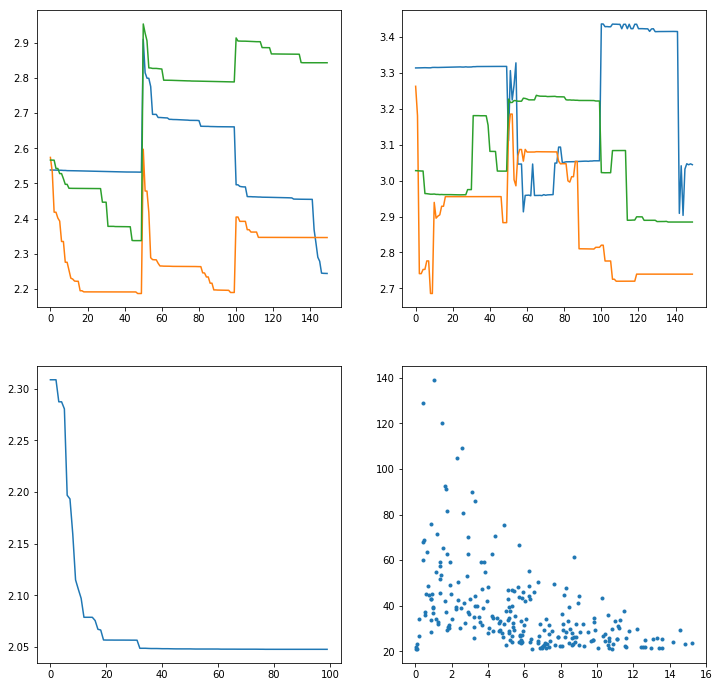

In [31]:
fig=plt.figure(figsize=(12,12))

ax1=fig.add_subplot(221)
ax1.plot(TrE[:,0])
ax1.plot(TrE[:,1])
ax1.plot(TrE[:,2])
ax2=fig.add_subplot(222)
ax2.plot(TsE[:,0])
ax2.plot(TsE[:,1])
ax2.plot(TsE[:,2])
ax3=fig.add_subplot(223)
ax3.plot(FTrE)


dis=[]
Ti=[]
for i in range(0,N-1):
    dis.append(distance(N-1,i,Sc[0,:8],Sc[0,8:11]))
    Ti.append(abs(T[i]-T[N-1]))

print(Sc)
print(estimate(N-1,range(N),Sc[0,:8],Sc[0,8:11],int(Sc[0,11]),True,False))

m=np.mean(dis)
dis2=[]
Ti2=[]
for i in range(N-1):
    if dis[i]<10*m:
        dis2.append(dis[i])
        Ti2.append(Ti[i])


        
    

ax4=fig.add_subplot(224)
ax4.plot(Ti2,dis2,'.')

plt.show()